In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import warnings
warnings.filterwarnings("ignore")

## 1. Exploratory Data Analysis

In [2]:
data = pd.read_csv("Churn_Modelling.csv")

In [3]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [4]:
print("Number of Rows:", data.shape[0], "\nNumber of Columns:", data.shape[1])

Number of Rows: 10000 
Number of Columns: 14


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
## We dont need row number, CustomerId, and Surname

In [7]:
data.drop(columns=["RowNumber", "CustomerId", "Surname"],axis=1, inplace=True)

In [8]:
print("New number of Rows:", data.shape[0], "\nNew number of Columns:", data.shape[1])

New number of Rows: 10000 
New number of Columns: 11


In [9]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### 2.1: Null Values

In [10]:
data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### 2.2 Target Variable Analysis

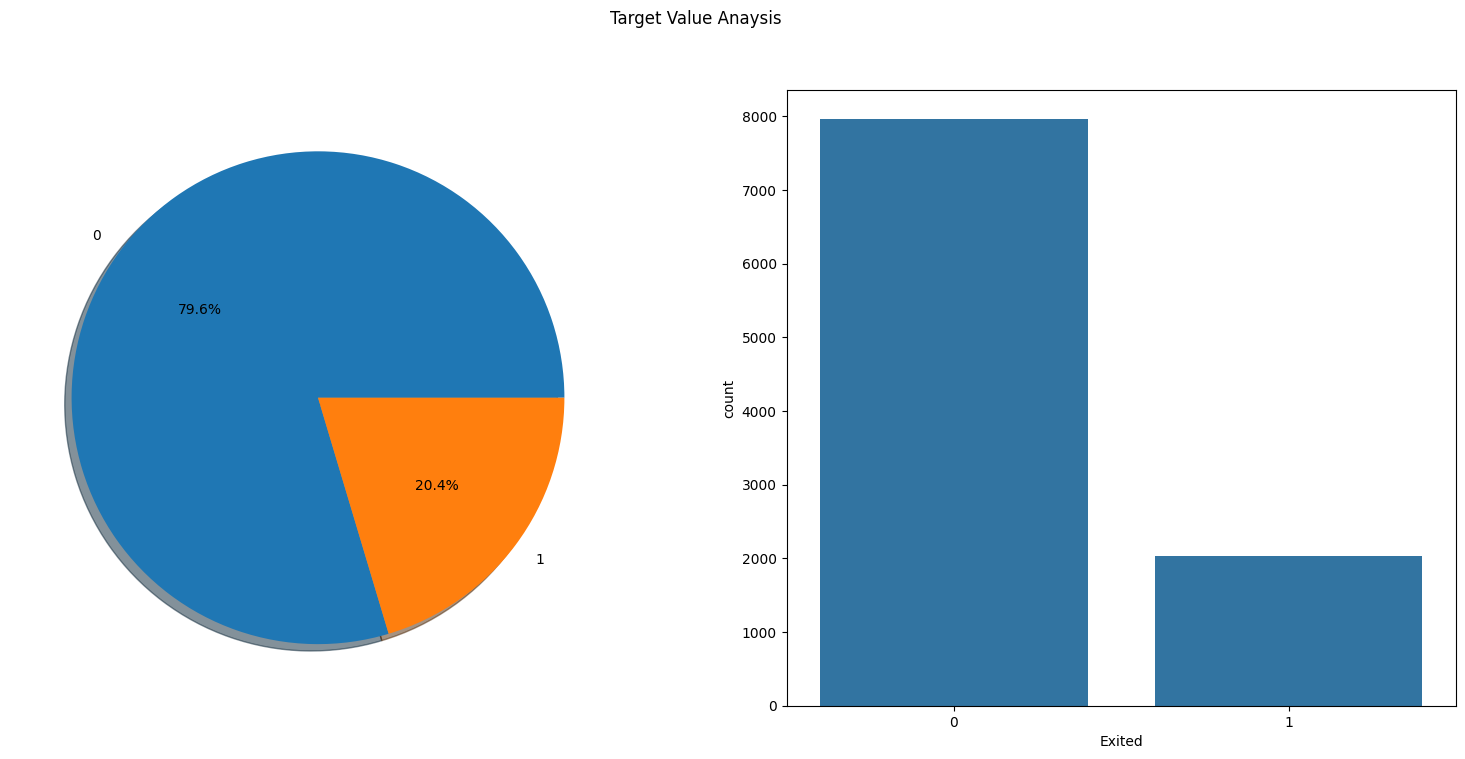

In [11]:
f,ax=plt.subplots(1,2,figsize=(19,8))
data['Exited'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x='Exited',data=data,ax=ax[1])
plt.suptitle('Target Value Anaysis')
plt.show()

Takeaways:

    - The data is highly imbalanced. ~ 80% of our data is from class 0 (not exited) and 20% of the data is from class 1 (exited)
    - With the purpose of this project being focused on predicting when a customer is going to leave, correctly predicting class 1 will be our priority.

### 2.3 Feature Variable Analysis

In [12]:
numeric_df = data.select_dtypes(include=['int64', 'float64'])
numeric_df.drop(['Exited'], axis=1, inplace=True)
categorical_df = data.select_dtypes(include='object')

#### 2.3a Categorical Variable Analysis

In [13]:
for col in categorical_df:
    print(f"Column: {col}")
    print(categorical_df[col].value_counts())
    print("\n")

Column: Geography
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64


Column: Gender
Gender
Male      5457
Female    4543
Name: count, dtype: int64




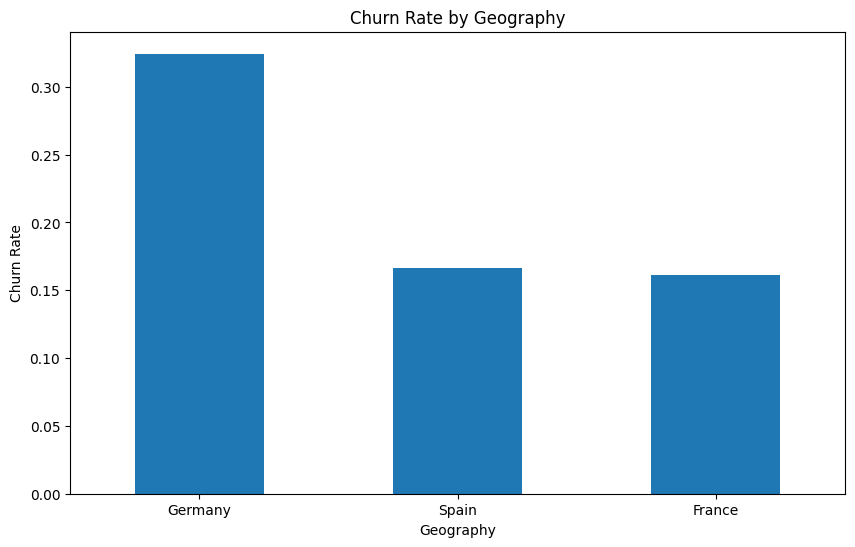

In [14]:
plt.figure(figsize=(10,6))
data.groupby('Geography')['Exited'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Churn Rate by Geography')
plt.xlabel('Geography')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.show()

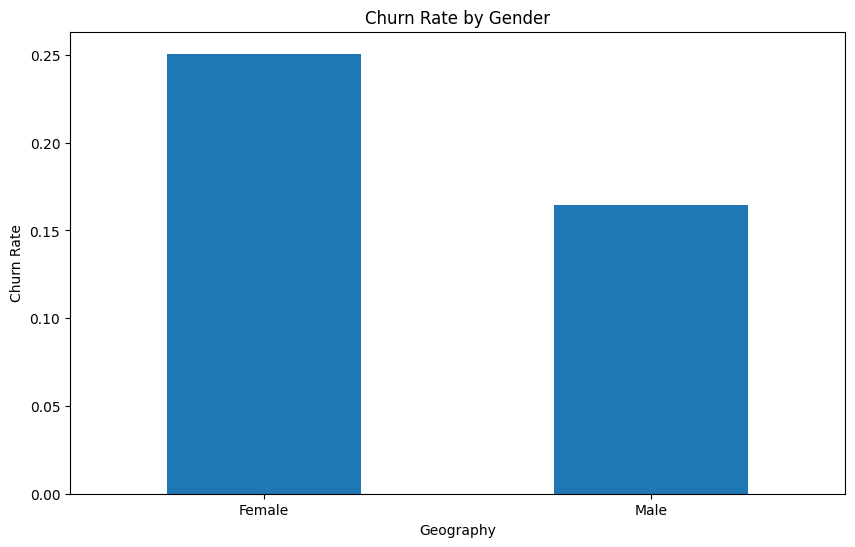

In [15]:
plt.figure(figsize=(10,6))
data.groupby('Gender')['Exited'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Churn Rate by Gender')
plt.xlabel('Geography')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.show()

#### 2.3b Numerical/Continuous Variable Analysis

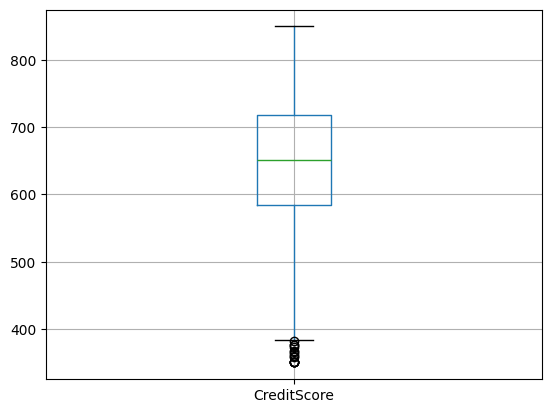

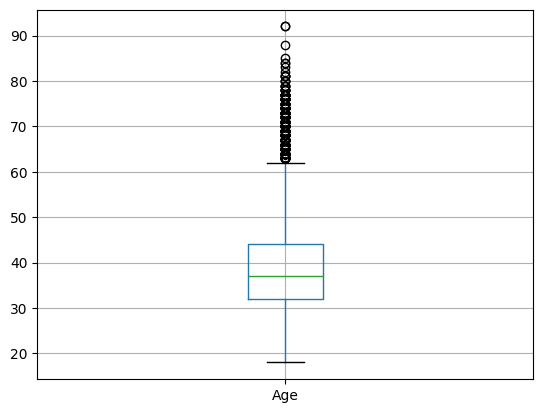

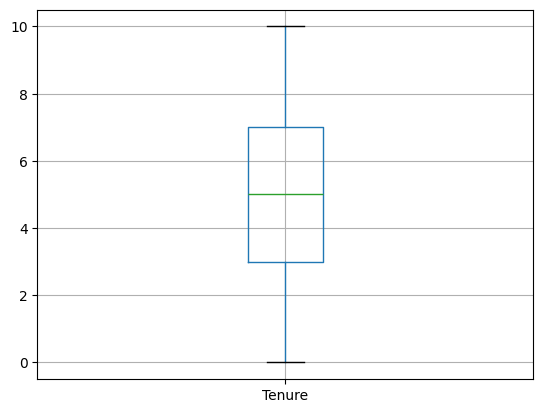

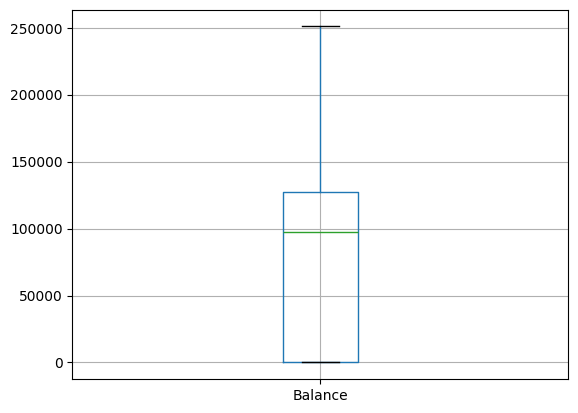

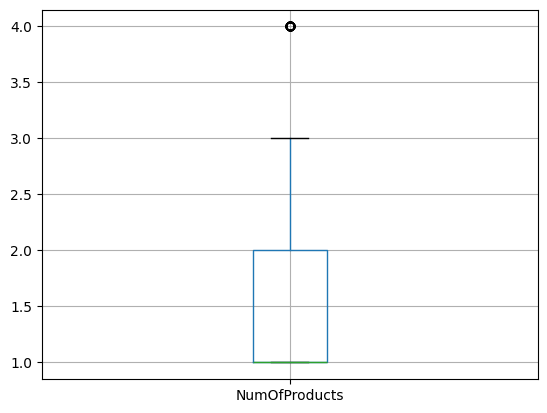

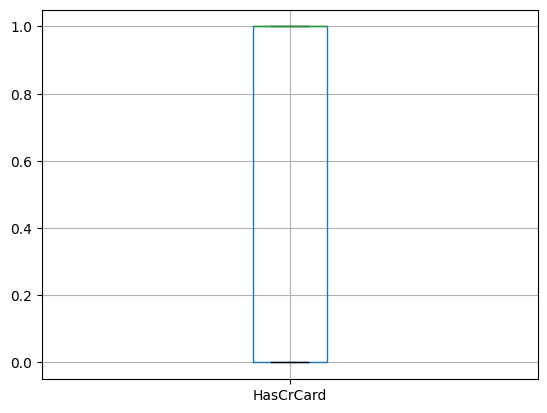

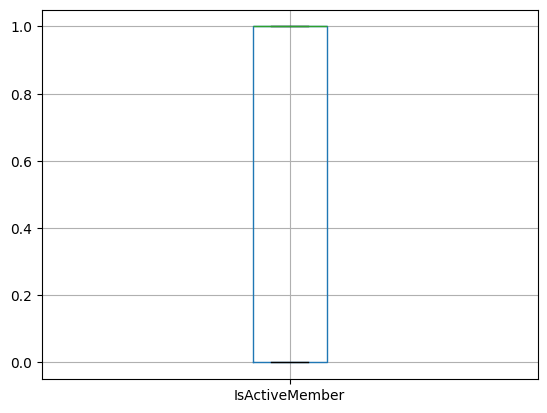

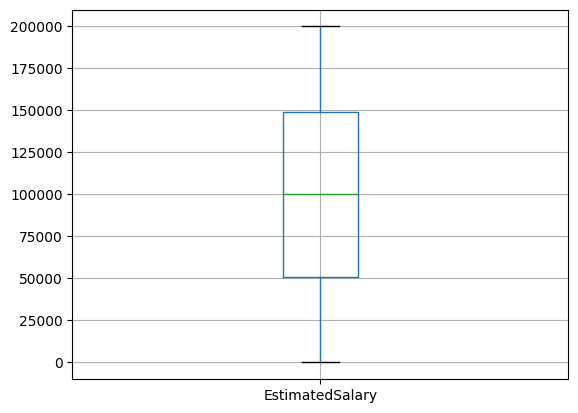

In [16]:
for col in numeric_df:
    data.boxplot(column=col)
    plt.show()

#### 2.3c Further Analyze Continuous Features

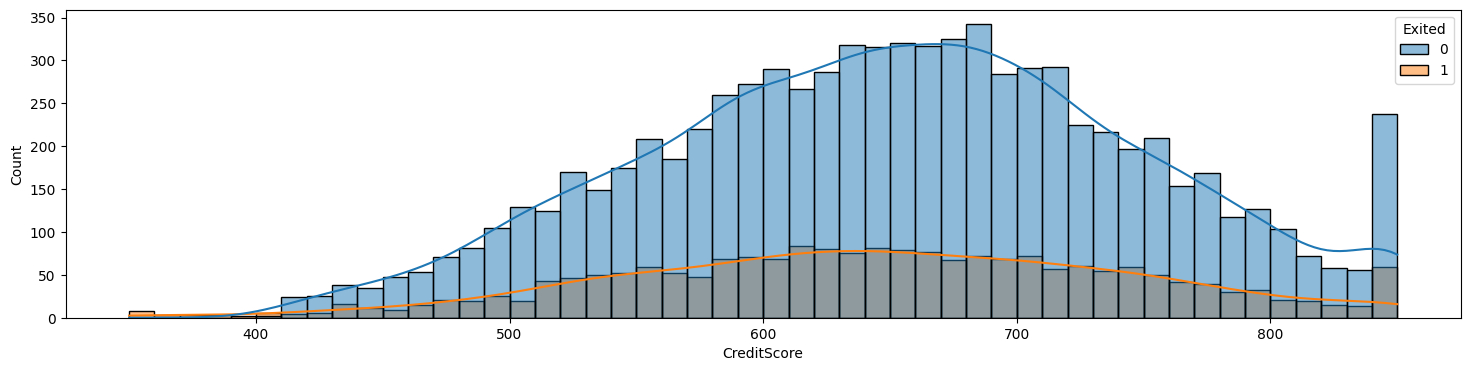

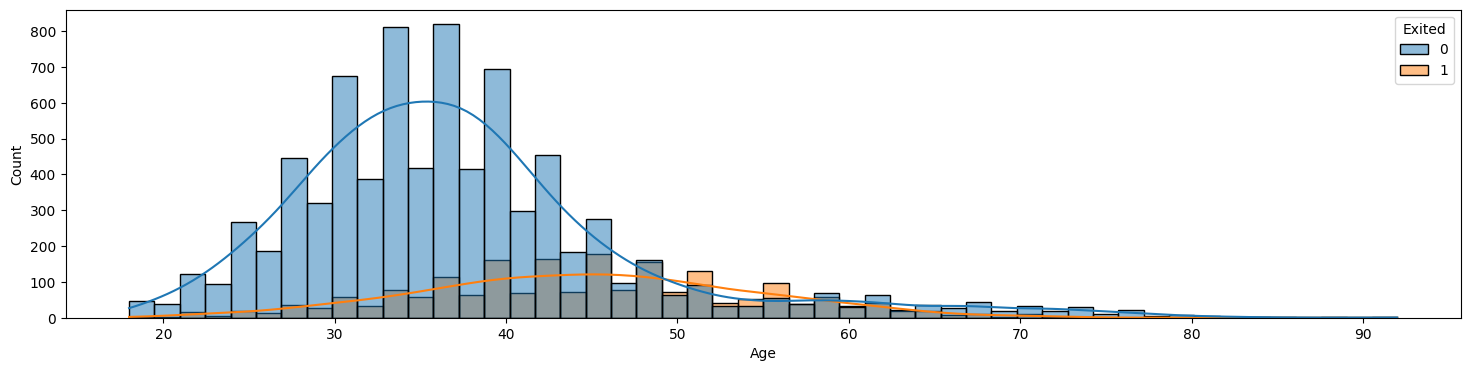

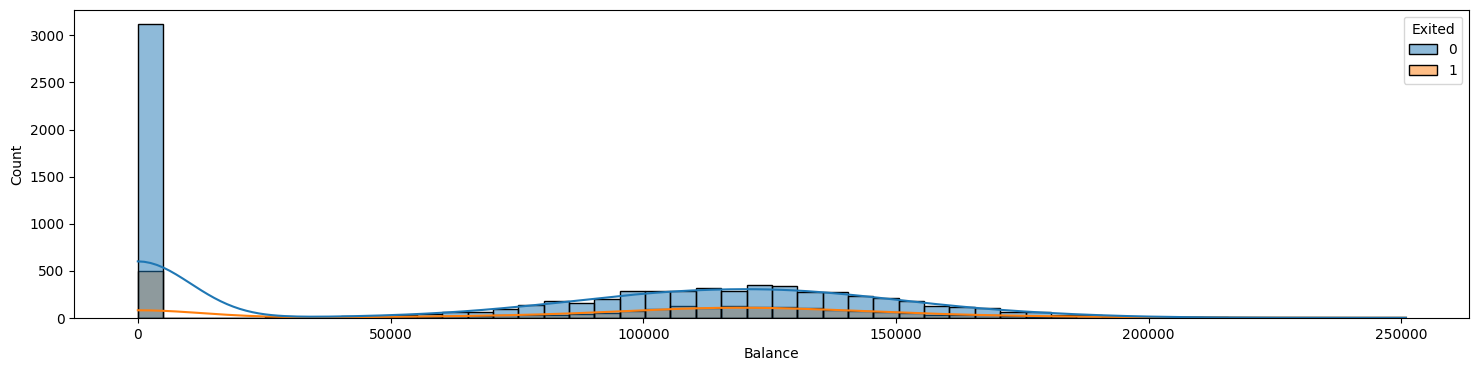

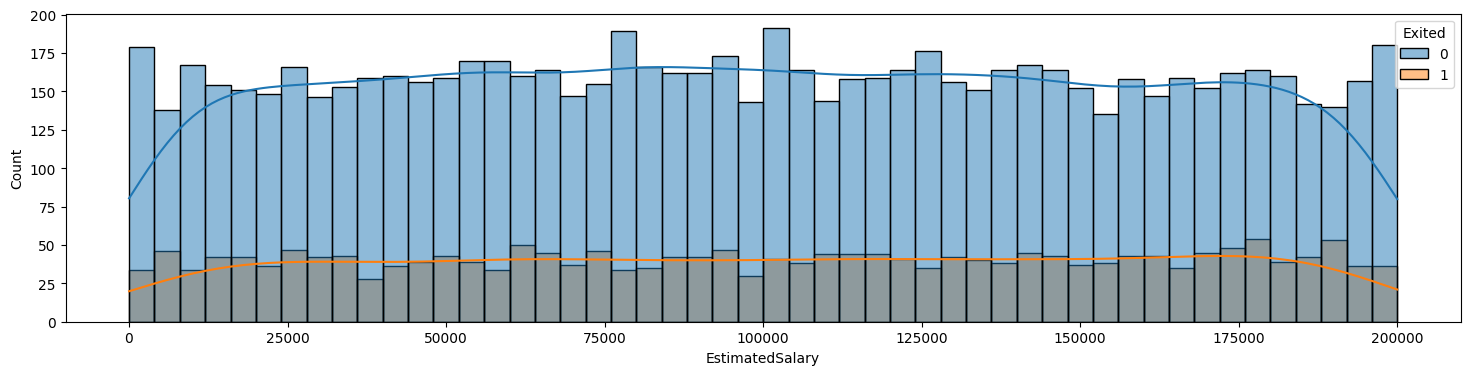

In [17]:
continuous = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for var in continuous:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=data, x=var, hue="Exited", bins=50, kde=True)
    plt.show()

## 3. Modeling 

### Overview

### 3.1: Data Preparation 

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Geography'] = label_encoder.fit_transform(data['Geography'])
data['Gender'] = label_encoder.fit_transform(data['Gender'])

In [20]:
data['Geography'].value_counts()

Geography
0    5014
1    2509
2    2477
Name: count, dtype: int64

In [21]:
data['Gender'].value_counts()

Gender
1    5457
0    4543
Name: count, dtype: int64

#### Split Data

In [22]:
X = data.drop(['Exited'], axis=1)
y = data['Exited']

In [23]:
X.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10
5,645,2,1,44,8,113755.78,2,1,0,149756.71
6,822,0,1,50,7,0.00,2,1,1,10062.80
7,376,1,0,29,4,115046.74,4,1,0,119346.88
8,501,0,1,44,4,142051.07,2,0,1,74940.50
9,684,0,1,27,2,134603.88,1,1,1,71725.73


In [24]:
y.head(10)

0    1
1    0
2    1
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: Exited, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 3.3: Create Model

In [26]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42)

model_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='auc', eval_set = [(X_test, y_test)])

[0]	validation_0-auc:0.83732
[1]	validation_0-auc:0.84990
[2]	validation_0-auc:0.85221
[3]	validation_0-auc:0.85772
[4]	validation_0-auc:0.85539
[5]	validation_0-auc:0.86046
[6]	validation_0-auc:0.86254
[7]	validation_0-auc:0.86250
[8]	validation_0-auc:0.86582
[9]	validation_0-auc:0.86778
[10]	validation_0-auc:0.86710
[11]	validation_0-auc:0.86944
[12]	validation_0-auc:0.86940
[13]	validation_0-auc:0.86920
[14]	validation_0-auc:0.86886
[15]	validation_0-auc:0.86847
[16]	validation_0-auc:0.86862
[17]	validation_0-auc:0.86747
[18]	validation_0-auc:0.86705
[19]	validation_0-auc:0.86702
[20]	validation_0-auc:0.86726


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 3.4: Evaluate Model

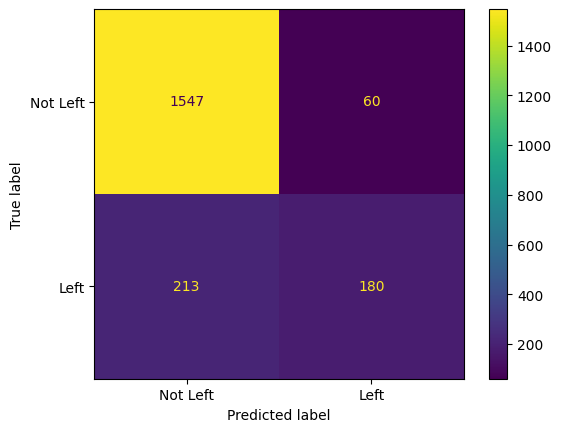

In [27]:
predictions = model_xgb.predict(X_test)

conf_m = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

In [28]:
accuracy = (conf_m[0,0] + conf_m[1,1]) / conf_m.sum()
print(f"Accuracy: {accuracy}")

Accuracy: 0.8635


In [29]:
# Calculate accuracy for class 0 (Not Left)
accuracy_class_0 = conf_m[0, 0] / conf_m[0, :].sum()

# Calculate accuracy for class 1 (Left)
accuracy_class_1 = conf_m[1, 1] / conf_m[1, :].sum()

print("Accuracy for class 'Not Left':", accuracy_class_0)
print("Accuracy for class 'Left':", accuracy_class_1)

Accuracy for class 'Not Left': 0.9626633478531424
Accuracy for class 'Left': 0.4580152671755725


In [30]:
# Calculate TP, FP, FN, TN
TP = conf_m[1, 1]  # True Positives
FP = conf_m[0, 1]  # False Positives
FN = conf_m[1, 0]  # False Negatives
TN = conf_m[0, 0]  # True Negatives

# Calculate Precision, Recall, and F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.75
Recall: 0.4580152671755725
F1 Score: 0.5687203791469195


### 3.5: Hyperparameter Tuning

In [32]:
from imblearn.over_sampling import SMOTE


In [33]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [34]:
from hyperopt import fmin, tpe, hp, STATUS_OK

In [35]:
# Define the hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 500, 50),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 1)
}

In [36]:
# Define the objective function to minimize
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['objective'] = 'binary:logistic'
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

In [37]:
# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|█████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16trial/s, best loss: -0.8705]
Best set of hyperparameters:  {'colsample_bytree': 0.6672050222652155, 'gamma': 0.2595478502857652, 'learning_rate': 0.05409448419859763, 'max_depth': 6.0, 'min_child_weight': 4.0, 'n_estimators': 500.0, 'reg_alpha': 0.6206802621603129, 'reg_lambda': 1.24454295172672, 'subsample': 0.7937196687853703}


In [38]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['seed'] = 42
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
hyperopt_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)

In [39]:
hyperopt_model.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.82585
[1]	validation_0-auc:0.83859
[2]	validation_0-auc:0.84885
[3]	validation_0-auc:0.85465
[4]	validation_0-auc:0.85547
[5]	validation_0-auc:0.85577
[6]	validation_0-auc:0.85500
[7]	validation_0-auc:0.85741
[8]	validation_0-auc:0.85813
[9]	validation_0-auc:0.85813
[10]	validation_0-auc:0.85836
[11]	validation_0-auc:0.85872
[12]	validation_0-auc:0.85869
[13]	validation_0-auc:0.86054
[14]	validation_0-auc:0.86075
[15]	validation_0-auc:0.86289
[16]	validation_0-auc:0.86342
[17]	validation_0-auc:0.86304
[18]	validation_0-auc:0.86496
[19]	validation_0-auc:0.86486
[20]	validation_0-auc:0.86482
[21]	validation_0-auc:0.86423
[22]	validation_0-auc:0.86394
[23]	validation_0-auc:0.86483
[24]	validation_0-auc:0.86633
[25]	validation_0-auc:0.86580
[26]	validation_0-auc:0.86546
[27]	validation_0-auc:0.86568
[28]	validation_0-auc:0.86594
[29]	validation_0-auc:0.86581
[30]	validation_0-auc:0.86590
[31]	validation_0-auc:0.86659
[32]	validation_0-auc:0.86730
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6672050222652155, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2595478502857652,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05409448419859763,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

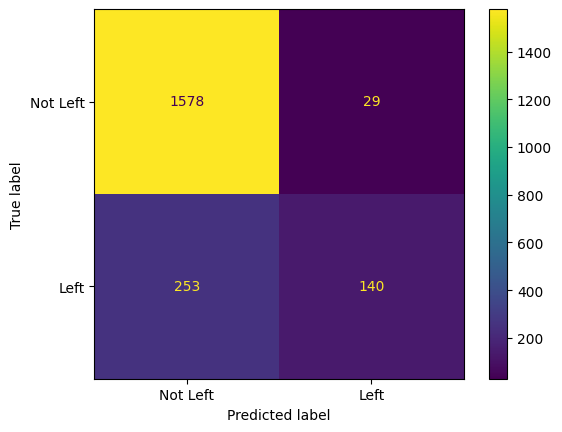

In [40]:
predictions = hyperopt_model.predict(X_test)

conf_m = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

In [41]:
accuracy = (conf_m[0,0] + conf_m[1,1]) / conf_m.sum()
print(f"Accuracy: {accuracy}")

Accuracy: 0.859


In [42]:
# Calculate accuracy for class 0 (Not Left)
accuracy_class_0 = conf_m[0, 0] / conf_m[0, :].sum()

# Calculate accuracy for class 1 (Left)
accuracy_class_1 = conf_m[1, 1] / conf_m[1, :].sum()

print("Accuracy for class 'Not Left':", accuracy_class_0)
print("Accuracy for class 'Left':", accuracy_class_1)

Accuracy for class 'Not Left': 0.9819539514623522
Accuracy for class 'Left': 0.356234096692112


In [43]:
# Calculate TP, FP, FN, TN
TP = conf_m[1, 1]  # True Positives
FP = conf_m[0, 1]  # False Positives
FN = conf_m[1, 0]  # False Negatives
TN = conf_m[0, 0]  # True Negatives

# Calculate Precision, Recall, and F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.8284023668639053
Recall: 0.356234096692112
F1 Score: 0.498220640569395


In [44]:
# Define the objective function to minimize
def objective_resample(params):
    params['max_depth'] = int(params['max_depth'])
    params['objective'] = 'binary:logistic'
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train_resampled, y_train_resampled)
    y_pred = xgb_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

In [45]:
# Perform the optimization
best_params = fmin(objective_resample, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|█████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.70trial/s, best loss: -0.8335]
Best set of hyperparameters:  {'colsample_bytree': 0.6772224886084126, 'gamma': 0.29301262873700756, 'learning_rate': 0.07525935289436533, 'max_depth': 7.0, 'min_child_weight': 1.0, 'n_estimators': 200.0, 'reg_alpha': 0.18216517002469423, 'reg_lambda': 0.4229587401895129, 'subsample': 0.9429440014553129}


In [46]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['seed'] = 42
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
hyperopt_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)

In [47]:
hyperopt_model.fit(X_train_resampled, y_train_resampled, verbose=True, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.80602
[1]	validation_0-auc:0.83801
[2]	validation_0-auc:0.84573
[3]	validation_0-auc:0.84151
[4]	validation_0-auc:0.84189
[5]	validation_0-auc:0.84385
[6]	validation_0-auc:0.84499
[7]	validation_0-auc:0.84589
[8]	validation_0-auc:0.84414
[9]	validation_0-auc:0.84446
[10]	validation_0-auc:0.84487
[11]	validation_0-auc:0.84405
[12]	validation_0-auc:0.84203
[13]	validation_0-auc:0.84285
[14]	validation_0-auc:0.84301
[15]	validation_0-auc:0.84410
[16]	validation_0-auc:0.84471
[17]	validation_0-auc:0.84588


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6772224886084126, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.29301262873700756,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07525935289436533,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

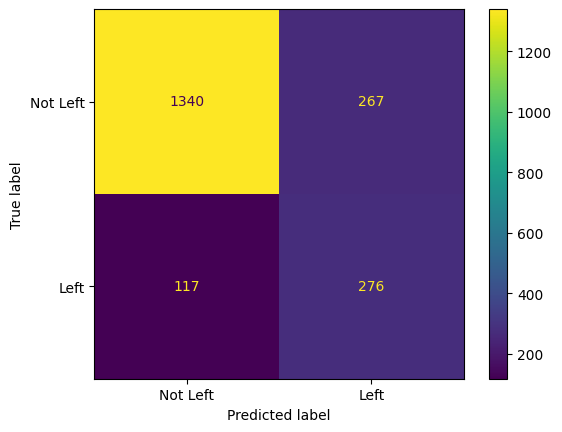

In [48]:
predictions = hyperopt_model.predict(X_test)

conf_m = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

In [49]:
accuracy = (conf_m[0,0] + conf_m[1,1]) / conf_m.sum()
print(f"Accuracy: {accuracy}")

Accuracy: 0.808


In [50]:
# Calculate accuracy for class 0 (Not Left)
accuracy_class_0 = conf_m[0, 0] / conf_m[0, :].sum()

# Calculate accuracy for class 1 (Left)
accuracy_class_1 = conf_m[1, 1] / conf_m[1, :].sum()

print("Accuracy for class 'Not Left':", accuracy_class_0)
print("Accuracy for class 'Left':", accuracy_class_1)

Accuracy for class 'Not Left': 0.8338518979464842
Accuracy for class 'Left': 0.7022900763358778


In [51]:
# Calculate TP, FP, FN, TN
TP = conf_m[1, 1]  # True Positives
FP = conf_m[0, 1]  # False Positives
FN = conf_m[1, 0]  # False Negatives
TN = conf_m[0, 0]  # True Negatives

# Calculate Precision, Recall, and F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.5082872928176796
Recall: 0.7022900763358778
F1 Score: 0.5897435897435898


In [30]:
# # Round 1

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.01, 0.1],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=3,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X_train,
                       y_train,
                       early_stopping_rounds=10,
                       eval_metric='auc',
                       eval_set=[(X_test, y_test)],
                       verbose=True)

print(optimal_parameters)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-auc:0.74738
[1]	validation_0-auc:0.82414
[2]	validation_0-auc:0.84617
[3]	validation_0-auc:0.85284
[4]	validation_0-auc:0.85583
[5]	validation_0-auc:0.85290
[6]	validation_0-auc:0.85765
[7]	validation_0-auc:0.85606
[8]	validation_0-auc:0.85699
[9]	validation_0-auc:0.85824
[10]	validation_0-auc:0.86088
[11]	validation_0-auc:0.86207
[12]	validation_0-auc:0.86198
[13]	validation_0-auc:0.86255
[14]	validation_0-auc:0.86296
[15]	validation_0-auc:0.86246
[16]	validation_0-auc:0.86242
[17]	validation_0-auc:0.86307
[18]	validation_0-auc:0.86464
[19]	validation_0-auc:0.86565
[20]	validation_0-auc:0.86599
[21]	validation_0-auc:0.86674
[22]	validation_0-auc:0.86682
[23]	validation_0-auc:0.86786
[24]	validation_0-auc:0.86887
[25]	validation_0-auc:0.86928
[26]	validation_0-auc:0.86990
[27]	validation_0-auc:0.87041
[28]	validation_0-auc:0.87063
[29]	validation_0-auc:0.87132
[30]	validation_0-auc:0.87132
[31]	validation_0

In [31]:
print(optimal_parameters.best_params_)

{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}


In [32]:
# # Round 2

param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.5, 1],
    'gamma': [1.0, 1.5, 2],
    'reg_lambda': [10.0, 25.0,50.0],
    'scale_pos_weight': [5, 7, 9]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=3,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X_train,
                       y_train,
                       early_stopping_rounds=10,
                       eval_metric='auc',
                       eval_set=[(X_test, y_test)],
                       verbose=True)

print(optimal_parameters.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-auc:0.74659
[1]	validation_0-auc:0.82247
[2]	validation_0-auc:0.83789
[3]	validation_0-auc:0.84697
[4]	validation_0-auc:0.85339
[5]	validation_0-auc:0.85397
[6]	validation_0-auc:0.85860
[7]	validation_0-auc:0.85686
[8]	validation_0-auc:0.85666
[9]	validation_0-auc:0.85638
[10]	validation_0-auc:0.85742
[11]	validation_0-auc:0.85955
[12]	validation_0-auc:0.86009
[13]	validation_0-auc:0.85977
[14]	validation_0-auc:0.86041
[15]	validation_0-auc:0.86065
[16]	validation_0-auc:0.86101
[17]	validation_0-auc:0.86337
[18]	validation_0-auc:0.86493
[19]	validation_0-auc:0.86406
[20]	validation_0-auc:0.86513
[21]	validation_0-auc:0.86602
[22]	validation_0-auc:0.86708
[23]	validation_0-auc:0.86724
[24]	validation_0-auc:0.86748
[25]	validation_0-auc:0.86792
[26]	validation_0-auc:0.86859
[27]	validation_0-auc:0.86918
[28]	validation_0-auc:0.86925
[29]	validation_0-auc:0.86937
[30]	validation_0-auc:0.86976
[31]	validation_0

In [33]:
# # Round 3

param_grid = {
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [2, 2.5, 3],
    'reg_lambda': [25.0, 50.0, 75.0],
    'scale_pos_weight': [7, 9, 11]
}

optimal_parameters = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=3,
    n_jobs=10,
    cv=3
)

optimal_parameters.fit(X_train,
                       y_train,
                       early_stopping_rounds=10,
                       eval_metric='auc',
                       eval_set=[(X_test, y_test)],
                       verbose=True)

print(optimal_parameters.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-auc:0.74434
[1]	validation_0-auc:0.82415
[2]	validation_0-auc:0.83594
[3]	validation_0-auc:0.84711
[4]	validation_0-auc:0.85130
[5]	validation_0-auc:0.85160
[6]	validation_0-auc:0.85602
[7]	validation_0-auc:0.85421
[8]	validation_0-auc:0.85446
[9]	validation_0-auc:0.85374
[10]	validation_0-auc:0.85463
[11]	validation_0-auc:0.85661
[12]	validation_0-auc:0.85740
[13]	validation_0-auc:0.85670
[14]	validation_0-auc:0.85781
[15]	validation_0-auc:0.85809
[16]	validation_0-auc:0.85832
[17]	validation_0-auc:0.86115
[18]	validation_0-auc:0.86265
[19]	validation_0-auc:0.86220
[20]	validation_0-auc:0.86339
[21]	validation_0-auc:0.86453
[22]	validation_0-auc:0.86559
[23]	validation_0-auc:0.86582
[24]	validation_0-auc:0.86581
[25]	validation_0-auc:0.86629
[26]	validation_0-auc:0.86722
[27]	validation_0-auc:0.86776
[28]	validation_0-auc:0.86778
[29]	validation_0-auc:0.86811
[30]	validation_0-auc:0.86842
[31]	validation_0

### 3.6: Tuned Models

In [35]:
## Round 1 Tuned Model
## {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}

clf_xgb_tuned_1 = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=1.0,
                               learning_rate=0.1,
                               max_depth=3,
                               reg_lambda=0,
                               scale_pos_weight=5,
                               subsample=0.9,
                               colsample_bytree=0.5)

clf_xgb_tuned_1.fit(X_train,
               y_train,
               verbose=True,
               early_stopping_rounds=10,
               eval_metric='auc',
               eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.74738
[1]	validation_0-auc:0.82414
[2]	validation_0-auc:0.84617
[3]	validation_0-auc:0.85284
[4]	validation_0-auc:0.85583
[5]	validation_0-auc:0.85290
[6]	validation_0-auc:0.85765
[7]	validation_0-auc:0.85606
[8]	validation_0-auc:0.85699
[9]	validation_0-auc:0.85824
[10]	validation_0-auc:0.86088
[11]	validation_0-auc:0.86207
[12]	validation_0-auc:0.86198
[13]	validation_0-auc:0.86255
[14]	validation_0-auc:0.86296
[15]	validation_0-auc:0.86246
[16]	validation_0-auc:0.86242
[17]	validation_0-auc:0.86307
[18]	validation_0-auc:0.86464
[19]	validation_0-auc:0.86565
[20]	validation_0-auc:0.86599
[21]	validation_0-auc:0.86674
[22]	validation_0-auc:0.86682
[23]	validation_0-auc:0.86786
[24]	validation_0-auc:0.86887
[25]	validation_0-auc:0.86928
[26]	validation_0-auc:0.86990
[27]	validation_0-auc:0.87041
[28]	validation_0-auc:0.87063
[29]	validation_0-auc:0.87132
[30]	validation_0-auc:0.87132
[31]	validation_0-auc:0.87192
[32]	validation_0-auc:0.87280
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

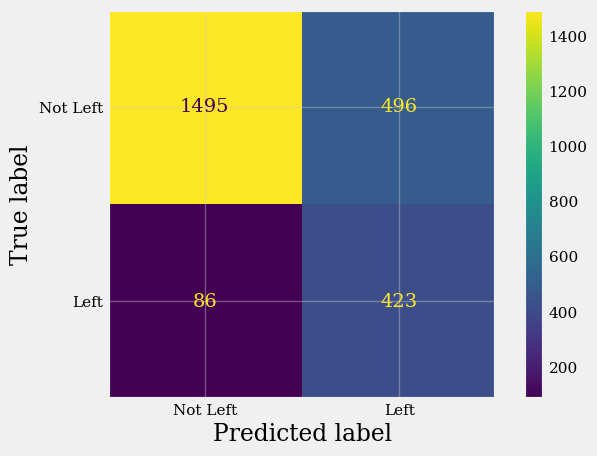

In [43]:
predictions_tuned_1 = clf_xgb_tuned_1.predict(X_test)

conf_m_t1 = confusion_matrix(y_test, predictions_tuned_1, labels=clf_xgb_tuned_1.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_m_t1, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

In [44]:
accuracy = (conf_m_t1[0,0] + conf_m_t1[1,1]) / conf_m_t1.sum()
print(f"Accuracy: {accuracy}")

Accuracy: 0.7672


In [45]:
# Calculate accuracy for class 0 (Not Left)
accuracy_class_0 = conf_m_t1[0, 0] / conf_m_t1[0, :].sum()

# Calculate accuracy for class 1 (Left)
accuracy_class_1 = conf_m_t1[1, 1] / conf_m_t1[1, :].sum()

print("Accuracy for class 'Not Left':", accuracy_class_0)
print("Accuracy for class 'Left':", accuracy_class_1)

Accuracy for class 'Not Left': 0.7508789552988449
Accuracy for class 'Left': 0.831041257367387


In [55]:
# Calculate TP, FP, FN for each class
TP = conf_m_t1[1, 1]  # True Positives
FP = conf_m_t1[0, 1]  # False Positives
FN = conf_m_t1[1, 0]  # False Negatives

# Calculate Precision, Recall, and F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.4602829162132753
Recall: 0.831041257367387
F1 Score: 0.592436974789916


In [41]:
## Round 2 Tuned Model
## {'gamma': 2, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 50.0, 'scale_pos_weight': 7}

clf_xgb_tuned_2 = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=2,
                               learning_rate=0.1,
                               max_depth=5,
                               reg_lambda=50.0,
                               scale_pos_weight=7,
                               subsample=0.9,
                               colsample_bytree=0.5)

clf_xgb_tuned_2.fit(X_train,
               y_train,
               verbose=True,
               early_stopping_rounds=10,
               eval_metric='auc',
               eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.74659
[1]	validation_0-auc:0.82247
[2]	validation_0-auc:0.83789
[3]	validation_0-auc:0.84697
[4]	validation_0-auc:0.85339
[5]	validation_0-auc:0.85397
[6]	validation_0-auc:0.85860
[7]	validation_0-auc:0.85686
[8]	validation_0-auc:0.85666
[9]	validation_0-auc:0.85638
[10]	validation_0-auc:0.85742
[11]	validation_0-auc:0.85955
[12]	validation_0-auc:0.86009
[13]	validation_0-auc:0.85977
[14]	validation_0-auc:0.86041
[15]	validation_0-auc:0.86065
[16]	validation_0-auc:0.86101
[17]	validation_0-auc:0.86337
[18]	validation_0-auc:0.86493
[19]	validation_0-auc:0.86406
[20]	validation_0-auc:0.86513
[21]	validation_0-auc:0.86602
[22]	validation_0-auc:0.86708
[23]	validation_0-auc:0.86724
[24]	validation_0-auc:0.86748
[25]	validation_0-auc:0.86792
[26]	validation_0-auc:0.86859
[27]	validation_0-auc:0.86918
[28]	validation_0-auc:0.86925
[29]	validation_0-auc:0.86937
[30]	validation_0-auc:0.86976
[31]	validation_0-auc:0.87090
[32]	validation_0-auc:0.87123
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

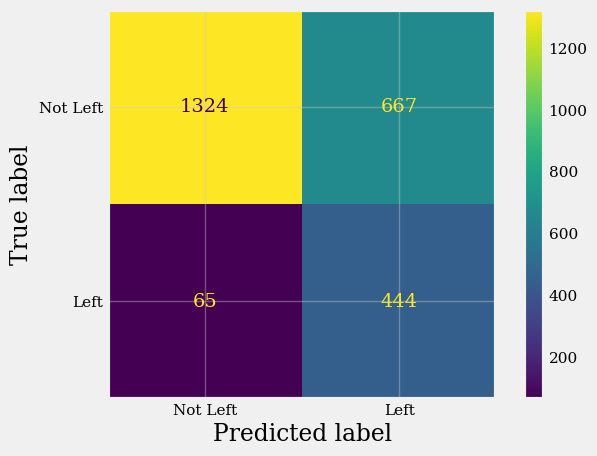

In [46]:
predictions_tuned_2 = clf_xgb_tuned_2.predict(X_test)

conf_m_t2 = confusion_matrix(y_test, predictions_tuned_2, labels=clf_xgb_tuned_2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_m_t2, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

In [47]:
accuracy = (conf_m_t2[0,0] + conf_m_t2[1,1]) / conf_m_t2.sum()
print(f"Accuracy: {accuracy}")

Accuracy: 0.7072


In [48]:
# Calculate accuracy for class 0 (Not Left)
accuracy_class_0 = conf_m_t2[0, 0] / conf_m_t2[0, :].sum()

# Calculate accuracy for class 1 (Left)
accuracy_class_1 = conf_m_t2[1, 1] / conf_m_t2[1, :].sum()

print("Accuracy for class 'Not Left':", accuracy_class_0)
print("Accuracy for class 'Left':", accuracy_class_1)

Accuracy for class 'Not Left': 0.6649924660974385
Accuracy for class 'Left': 0.8722986247544204


In [54]:
# Calculate TP, FP, FN for each class
TP = conf_m_t2[1, 1]  # True Positives
FP = conf_m_t2[0, 1]  # False Positives
FN = conf_m_t2[1, 0]  # False Negatives

# Calculate Precision, Recall, and F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.3996399639963996
Recall: 0.8722986247544204
F1 Score: 0.5481481481481482


In [49]:
## Round 3 Tuned Model
## {'gamma': 2.5, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 50.0, 'scale_pos_weight': 9}

clf_xgb_tuned_3 = xgb.XGBClassifier(seed=42,
                               objective='binary:logistic',
                               gamma=2.5,
                               learning_rate=0.1,
                               max_depth=5,
                               reg_lambda=50.0,
                               scale_pos_weight=9,
                               subsample=0.9,
                               colsample_bytree=0.5)

clf_xgb_tuned_3.fit(X_train,
               y_train,
               verbose=True,
               early_stopping_rounds=10,
               eval_metric='auc',
               eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.74434
[1]	validation_0-auc:0.82415
[2]	validation_0-auc:0.83594
[3]	validation_0-auc:0.84711
[4]	validation_0-auc:0.85130
[5]	validation_0-auc:0.85160
[6]	validation_0-auc:0.85602
[7]	validation_0-auc:0.85421
[8]	validation_0-auc:0.85446
[9]	validation_0-auc:0.85374
[10]	validation_0-auc:0.85463
[11]	validation_0-auc:0.85661
[12]	validation_0-auc:0.85740
[13]	validation_0-auc:0.85670
[14]	validation_0-auc:0.85781
[15]	validation_0-auc:0.85809
[16]	validation_0-auc:0.85832
[17]	validation_0-auc:0.86115
[18]	validation_0-auc:0.86265
[19]	validation_0-auc:0.86220
[20]	validation_0-auc:0.86339
[21]	validation_0-auc:0.86453
[22]	validation_0-auc:0.86559
[23]	validation_0-auc:0.86582
[24]	validation_0-auc:0.86581
[25]	validation_0-auc:0.86629
[26]	validation_0-auc:0.86722
[27]	validation_0-auc:0.86776
[28]	validation_0-auc:0.86778
[29]	validation_0-auc:0.86811
[30]	validation_0-auc:0.86842
[31]	validation_0-auc:0.86954
[32]	validation_0-auc:0.86977
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

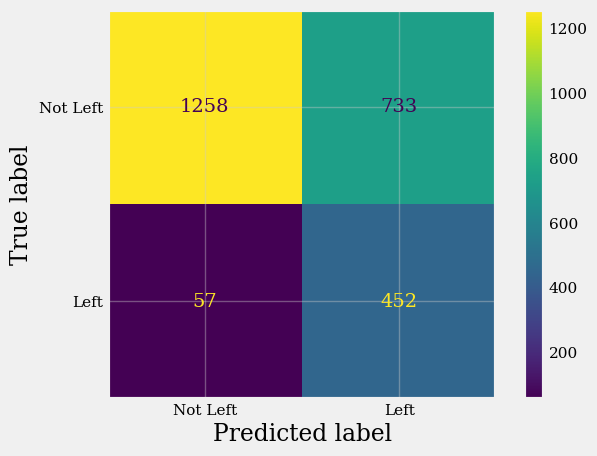

In [50]:
predictions_tuned_3 = clf_xgb_tuned_3.predict(X_test)

conf_m_t3 = confusion_matrix(y_test, predictions_tuned_3, labels=clf_xgb_tuned_3.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_m_t3, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

In [51]:
accuracy = (conf_m_t3[0,0] + conf_m_t3[1,1]) / conf_m_t3.sum()
print(f"Accuracy: {accuracy}")

Accuracy: 0.684


In [52]:
# Calculate accuracy for class 0 (Not Left)
accuracy_class_0 = conf_m_t3[0, 0] / conf_m_t3[0, :].sum()

# Calculate accuracy for class 1 (Left)
accuracy_class_1 = conf_m_t3[1, 1] / conf_m_t3[1, :].sum()

print("Accuracy for class 'Not Left':", accuracy_class_0)
print("Accuracy for class 'Left':", accuracy_class_1)

Accuracy for class 'Not Left': 0.6318432948267202
Accuracy for class 'Left': 0.888015717092338


In [53]:
# Calculate TP, FP, FN for each class
TP = conf_m_t3[1, 1]  # True Positives
FP = conf_m_t3[0, 1]  # False Positives
FN = conf_m_t3[1, 0]  # False Negatives

# Calculate Precision, Recall, and F1 score
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.38143459915611816
Recall: 0.888015717092338
F1 Score: 0.5336481700118064
